# Method 1 - Segmentation by product category
Creating "personas" - a proxy for subsets of your audience that have similar interests, priorities and problems to be solved.

### Joining useful tables

In [1]:
import pandas as pd

customers_data = pd.read_csv('olist_customers_dataset.csv')
order_items_data = pd.read_csv('olist_order_items_dataset.csv')
products_data = pd.read_csv('olist_products_dataset.csv')
translation_data = pd.read_csv('product_category_name_translation.csv')
orders_data = pd.read_csv('olist_orders_dataset.csv')

In [2]:
# Replacing PT categories with EN
category_translations = dict(zip(translation_data['product_category_name'],translation_data['product_category_name_english']))
products_data = products_data.replace({'product_category_name':category_translations})

# Joining datasets to get only data required for segmentation
segment_data = pd.merge(customers_data.drop(['customer_zip_code_prefix','customer_city'],axis=1),orders_data[['order_id','customer_id']],on='customer_id')
segment_data = pd.merge(segment_data,order_items_data[['order_id','product_id','price']],on='order_id')
segment_data = pd.merge(segment_data,products_data[['product_id','product_category_name']])
segment_data = segment_data.dropna()

In [3]:
segment_data.head()

,customer_id,customer_unique_id,customer_state,order_id,product_id,price,product_category_name
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP,00e7ee1b050b8499577073aeb2a297a1,a9516a079e37a9c9c36b9b78b10169e8,124.99,office_furniture
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,PA,c1d2b34febe9cd269e378117d6681172,a9516a079e37a9c9c36b9b78b10169e8,112.99,office_furniture
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,PA,c1d2b34febe9cd269e378117d6681172,a9516a079e37a9c9c36b9b78b10169e8,112.99,office_furniture
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,RS,b1a5d5365d330d10485e0203d54ab9e8,a9516a079e37a9c9c36b9b78b10169e8,124.99,office_furniture
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,RJ,2e604b3614664aa66867856dba7e61b7,a9516a079e37a9c9c36b9b78b10169e8,106.99,office_furniture


In [4]:
segment_data.product_category_name.unique()

array(['office_furniture', 'housewares', 'home_confort', 'sports_leisure',
       'computers_accessories', 'toys', 'furniture_decor', 'auto',
       'air_conditioning', 'telephony', 'health_beauty', 'garden_tools',
       'pet_shop', 'bed_bath_table', 'baby', 'watches_gifts',
       'kitchen_dining_laundry_garden_furniture', 'perfumery', 'art',
       'stationery', 'fashio_female_clothing', 'consoles_games',
       'construction_tools_lights', 'food_drink', 'drinks', 'cool_stuff',
       'fashion_bags_accessories', 'home_construction',
       'luggage_accessories', 'electronics', 'home_appliances_2',
       'fashion_male_clothing', 'small_appliances',
       'small_appliances_home_oven_and_coffee', 'books_general_interest',
       'home_appliances', 'costruction_tools_tools',
       'signaling_and_security', 'musical_instruments',
       'construction_tools_construction', 'music', 'fashion_shoes',
       'industry_commerce_and_business', 'fashion_underwear_beach',
       'dvds_blu_ray'

### No. of products ordered per customer_unique_id

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

products_by_unique = segment_data['customer_unique_id'].value_counts()
products_by_unique = products_by_unique.value_counts().sort_index().to_frame().reset_index()
products_by_unique = products_by_unique.rename(columns={'index':'Total # of orders','customer_unique_id':'No. of unique customers'})
products_by_unique.head()

,Total # of orders,No. of unique customers
0,1,82433
1,2,8854
2,3,1638
3,4,623
4,5,251


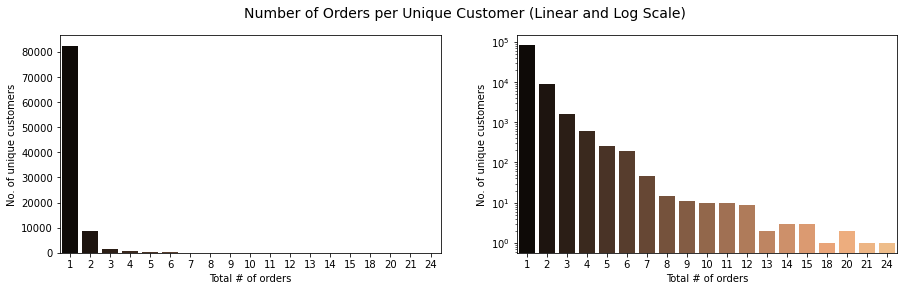

In [6]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

plt.suptitle("Number of Orders per Unique Customer (Linear and Log Scale)", fontsize=14)

sns.barplot(data=products_by_unique, x='Total # of orders', y='No. of unique customers',ax=ax[0], palette='copper')
sns.barplot(data=products_by_unique, x='Total # of orders', y='No. of unique customers',ax=ax[1], palette='copper')
ax[1].set_yscale('log')

There are 94,108 unique customers, purchasing a total of 111,047 products. 87.6% (82,433 people) of those unique customers only ordered once within the period of 2016 - 2018.

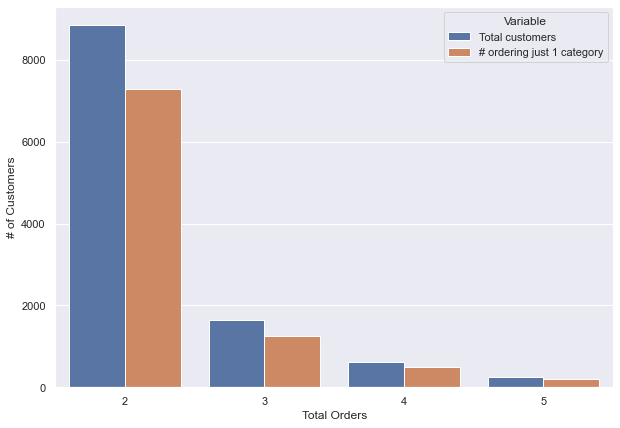

In [7]:
# From the perspective of a unique customer, inc. no of orders, amount spent, total products purchased by product category.
segment_data_by_unique = segment_data[['customer_unique_id','order_id','price','product_category_name']]

# One hot encode all categories purchased by unique id
one_hot = pd.get_dummies(segment_data_by_unique['product_category_name'])
segment_data_by_unique = segment_data_by_unique.drop('product_category_name',axis=1)
segment_data_by_unique = segment_data_by_unique.join(one_hot)

# Replace order_id with 1 (so groupby can sum total orders)
segment_data_by_unique['order_id'] = 1

# Groupby and sum
segment_data_by_unique = segment_data_by_unique.groupby(['customer_unique_id']).sum()

# Remove order_id and price
segment_data_by_unique = segment_data_by_unique.drop(['order_id','price'],axis=1)

# Keeping only customers that purchased more than 2 categories
unique_single = segment_data_by_unique
unique_single['Total'] = segment_data_by_unique.sum(1)
unique_single['Single Category only'] = unique_single.drop('Total',1).isin(unique_single['Total']).any(1)
unique_single = unique_single.loc[unique_single['Single Category only'] == False].drop(['Single Category only','Total'],1)

# Remove all columns for which sum() = 0
unique_single = unique_single.loc[:, (unique_single.sum(axis=0) != 0)]

# Used to work out number of users purchasing multiple items
len(segment_data_by_unique.loc[segment_data_by_unique.sum(1).eq(5)])

# Used to work out number of users purchasing single category
unique_single.sum(1).value_counts()

single_category_users = pd.DataFrame({'Total Orders': [2,3,4,5],
                                      'Total customers': [8854,1638,623,251],
                                     '# ordering just 1 category': [8854 - 1577, 1638 - 390, 623 - 136, 251 - 58]})

# Show users sticking to one category
sns.set(rc={'figure.figsize':(10,7)})
tidy = single_category_users.melt(id_vars='Total Orders').rename(columns=str.title)
ax = sns.barplot(x='Total Orders', y='Value', hue='Variable', data=tidy)
ax.set(ylabel='# of Customers')
plt.show()

Of the remaining customers that bought more than once, the vast majority still stick to one category. 

### Clustering 

- standardize data set 
   - StandardScaler, Normalizer
- dimensionality reduction 
   - Principal Component Analysis (PCA)
   - Singular value decomposition(SVD)
- clustering algorithm 
   - KMeans
   - Kmodes
   - Agglomerative 

We try out a few combinations of different dimensionality reduction and clustering techniques to get an intuition of the output, then choosing the combination that provides the most representative/cleanest clusters. We eventually settled on a combination of SVD and Agglomerative Clustering.

In [8]:
# Import libraries for different preprocessing, dimensionality reduction and clustering techniques
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from kmodes.kmodes import KModes
from sklearn.pipeline import Pipeline

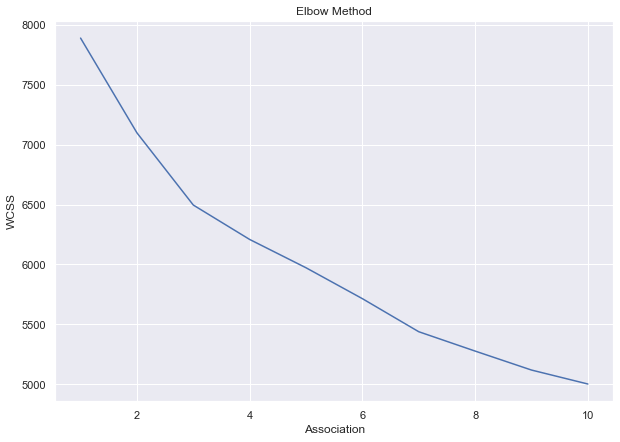

In [9]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                    max_iter = 400, n_init = 10, random_state = 0)
    kmeans.fit(unique_single)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Association')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [10]:
n_clusters = 8

# Define techniques
standard = StandardScaler()
normalizer = Normalizer()
pca = PCA()
svd = TruncatedSVD(n_components=20)
agglomerative = AgglomerativeClustering(n_clusters=n_clusters, compute_distances=True, linkage='ward')
kmeans = KMeans(n_clusters=8, n_init=50, max_iter=300)
kmodes = KModes(n_clusters=4, n_init=4, init='Cao')

In [24]:
#unique_single

#### Method1 - pca + kmodes

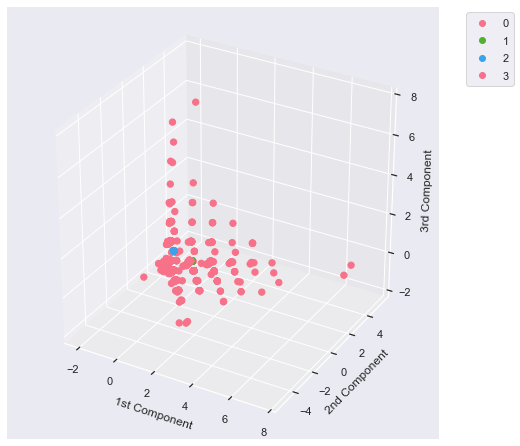

In [12]:
# similar to method 3
pipe = Pipeline([('reduce_dim',pca),('clustering',kmodes)])
clusters = pipe.fit_predict(unique_single)

# Visualization using top 3 (of 20) components to show clustering
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

output = pipe.named_steps['reduce_dim'].fit_transform(unique_single)

df = pd.DataFrame(output)
df = df[[0,1,2]]
df['Clusters'] = clusters
df['Clusters'].value_counts()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df[0], df[1], df[2], s=40, c=df['Clusters'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('1st Component')
ax.set_ylabel('2nd Component')
ax.set_zlabel('3rd Component')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

#### Method1 - normalize + pca + kmodes

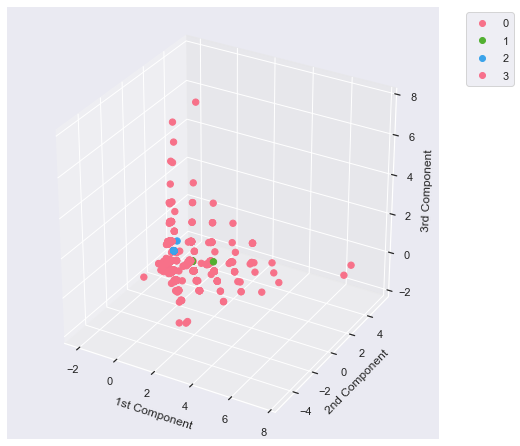

In [13]:
pipe = Pipeline([('nor',normalizer),('reduce_dim',pca),('clustering',kmodes)])
clusters = pipe.fit_predict(unique_single)

# Visualization using top 3 (of 20) components to show clustering
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

output = pipe.named_steps['reduce_dim'].fit_transform(unique_single)

df = pd.DataFrame(output)
df = df[[0,1,2]]
df['Clusters'] = clusters
df['Clusters'].value_counts()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df[0], df[1], df[2], s=40, c=df['Clusters'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('1st Component')
ax.set_ylabel('2nd Component')
ax.set_zlabel('3rd Component')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

#### Method1 - standardize + pca + kmodes

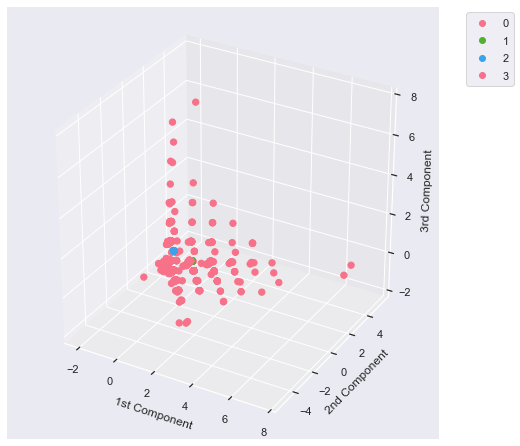

In [14]:
pipe = Pipeline([('std',standard),('reduce_dim',pca),('clustering',kmodes)])
clusters = pipe.fit_predict(unique_single)

# Visualization using top 3 (of 20) components to show clustering
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

output = pipe.named_steps['reduce_dim'].fit_transform(unique_single)

df = pd.DataFrame(output)
df = df[[0,1,2]]
df['Clusters'] = clusters
df['Clusters'].value_counts()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df[0], df[1], df[2], s=40, c=df['Clusters'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('1st Component')
ax.set_ylabel('2nd Component')
ax.set_zlabel('3rd Component')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

#### Method2 - pca + kmeans

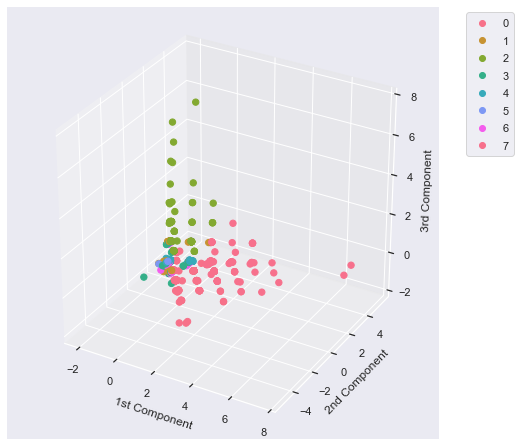

In [15]:
# contains some mishmash
pipe = Pipeline([('reduce_dim',pca),('clustering',kmeans)])
clusters = pipe.fit_predict(unique_single)

# Visualization using top 3 (of 20) components to show clustering
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

output = pipe.named_steps['reduce_dim'].fit_transform(unique_single)

df = pd.DataFrame(output)
df = df[[0,1,2]]
df['Clusters'] = clusters
df['Clusters'].value_counts()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df[0], df[1], df[2], s=40, c=df['Clusters'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('1st Component')
ax.set_ylabel('2nd Component')
ax.set_zlabel('3rd Component')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

#### Method3 - pca + agglomerative

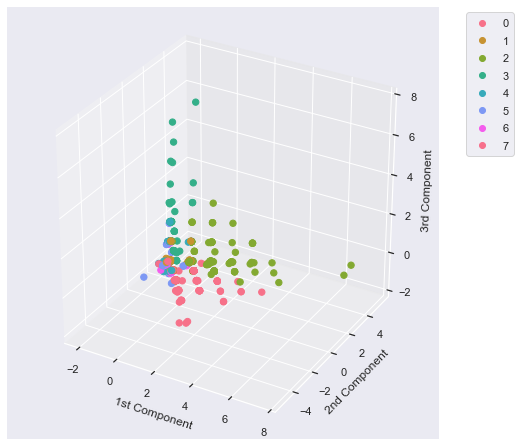

In [16]:
# relatively good, but contains some mishmash
pipe = Pipeline([('reduce_dim',pca),('clustering',agglomerative)])
clusters = pipe.fit_predict(unique_single)

# Visualization using top 3 (of 20) components to show clustering
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

output = pipe.named_steps['reduce_dim'].fit_transform(unique_single)

df = pd.DataFrame(output)
df = df[[0,1,2]]
df['Clusters'] = clusters
df['Clusters'].value_counts()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df[0], df[1], df[2], s=40, c=df['Clusters'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('1st Component')
ax.set_ylabel('2nd Component')
ax.set_zlabel('3rd Component')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

#### Method4 - svd + kmodes

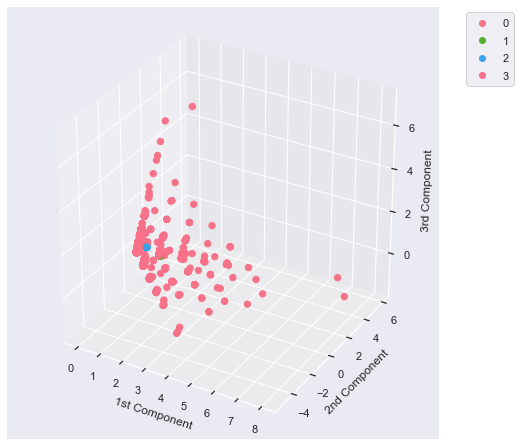

In [17]:
# almost all in one cluster
pipe = Pipeline([('reduce_dim',svd),('clustering',kmodes)])
clusters = pipe.fit_predict(unique_single)

# Visualization using top 3 (of 20) components to show clustering
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

output = pipe.named_steps['reduce_dim'].fit_transform(unique_single)

df = pd.DataFrame(output)
df = df[[0,1,2]]
df['Clusters'] = clusters
df['Clusters'].value_counts()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df[0], df[1], df[2], s=40, c=df['Clusters'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('1st Component')
ax.set_ylabel('2nd Component')
ax.set_zlabel('3rd Component')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

#### Method5 - svd + kmeans

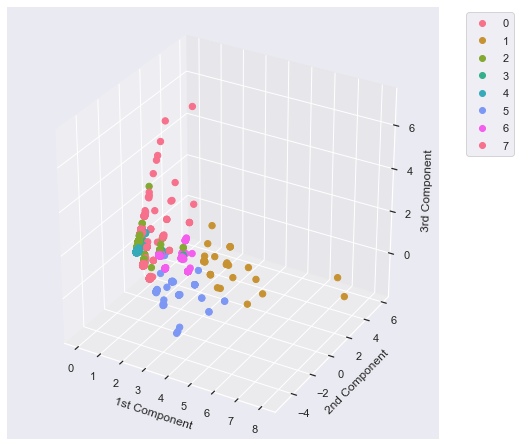

In [18]:
# looks clean
pipe = Pipeline([('reduce_dim',svd),('clustering',kmeans)])
clusters = pipe.fit_predict(unique_single)
# Visualization using top 3 (of 20) components to show clustering
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

output = pipe.named_steps['reduce_dim'].fit_transform(unique_single)

df = pd.DataFrame(output)
df = df[[0,1,2]]
df['Clusters'] = clusters
df['Clusters'].value_counts()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df[0], df[1], df[2], s=40, c=df['Clusters'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('1st Component')
ax.set_ylabel('2nd Component')
ax.set_zlabel('3rd Component')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

#### Method6 - standardize + svd + agglomerative

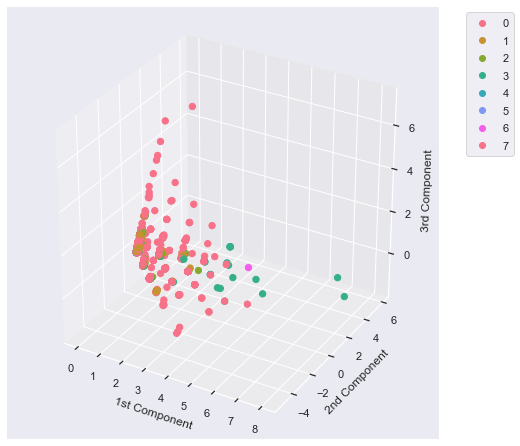

In [19]:
pipe = Pipeline([('std',standard),('reduce_dim',svd),('clustering',agglomerative)])
clusters = pipe.fit_predict(unique_single)

# Visualization using top 3 (of 20) components to show clustering
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

output = pipe.named_steps['reduce_dim'].fit_transform(unique_single)

df = pd.DataFrame(output)
df = df[[0,1,2]]
df['Clusters'] = clusters
df['Clusters'].value_counts()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df[0], df[1], df[2], s=40, c=df['Clusters'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('1st Component')
ax.set_ylabel('2nd Component')
ax.set_zlabel('3rd Component')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

#### Method6 - svd + agglomerative

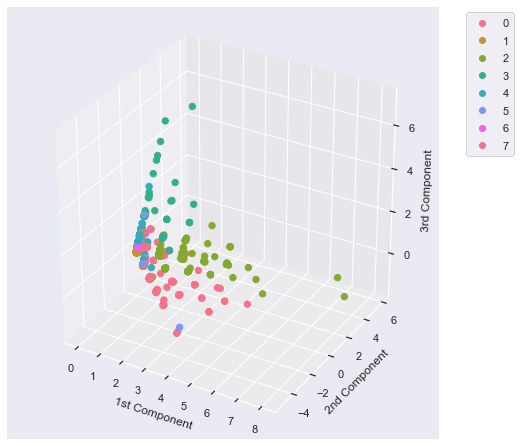

In [20]:
# Fit whichever produces cleanest clusters
# looks clean
pipe = Pipeline([('reduce_dim',svd),('clustering',agglomerative)])
clusters = pipe.fit_predict(unique_single)

# Visualization using top 3 (of 20) components to show clustering
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

output = pipe.named_steps['reduce_dim'].fit_transform(unique_single)

df = pd.DataFrame(output)
df = df[[0,1,2]]
df['Clusters'] = clusters
df['Clusters'].value_counts()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(df[0], df[1], df[2], s=40, c=df['Clusters'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('1st Component')
ax.set_ylabel('2nd Component')
ax.set_zlabel('3rd Component')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

### Final Cluster

While the the final iteration yielded 8 separate clusters, some category connections were spread across several different clusters.

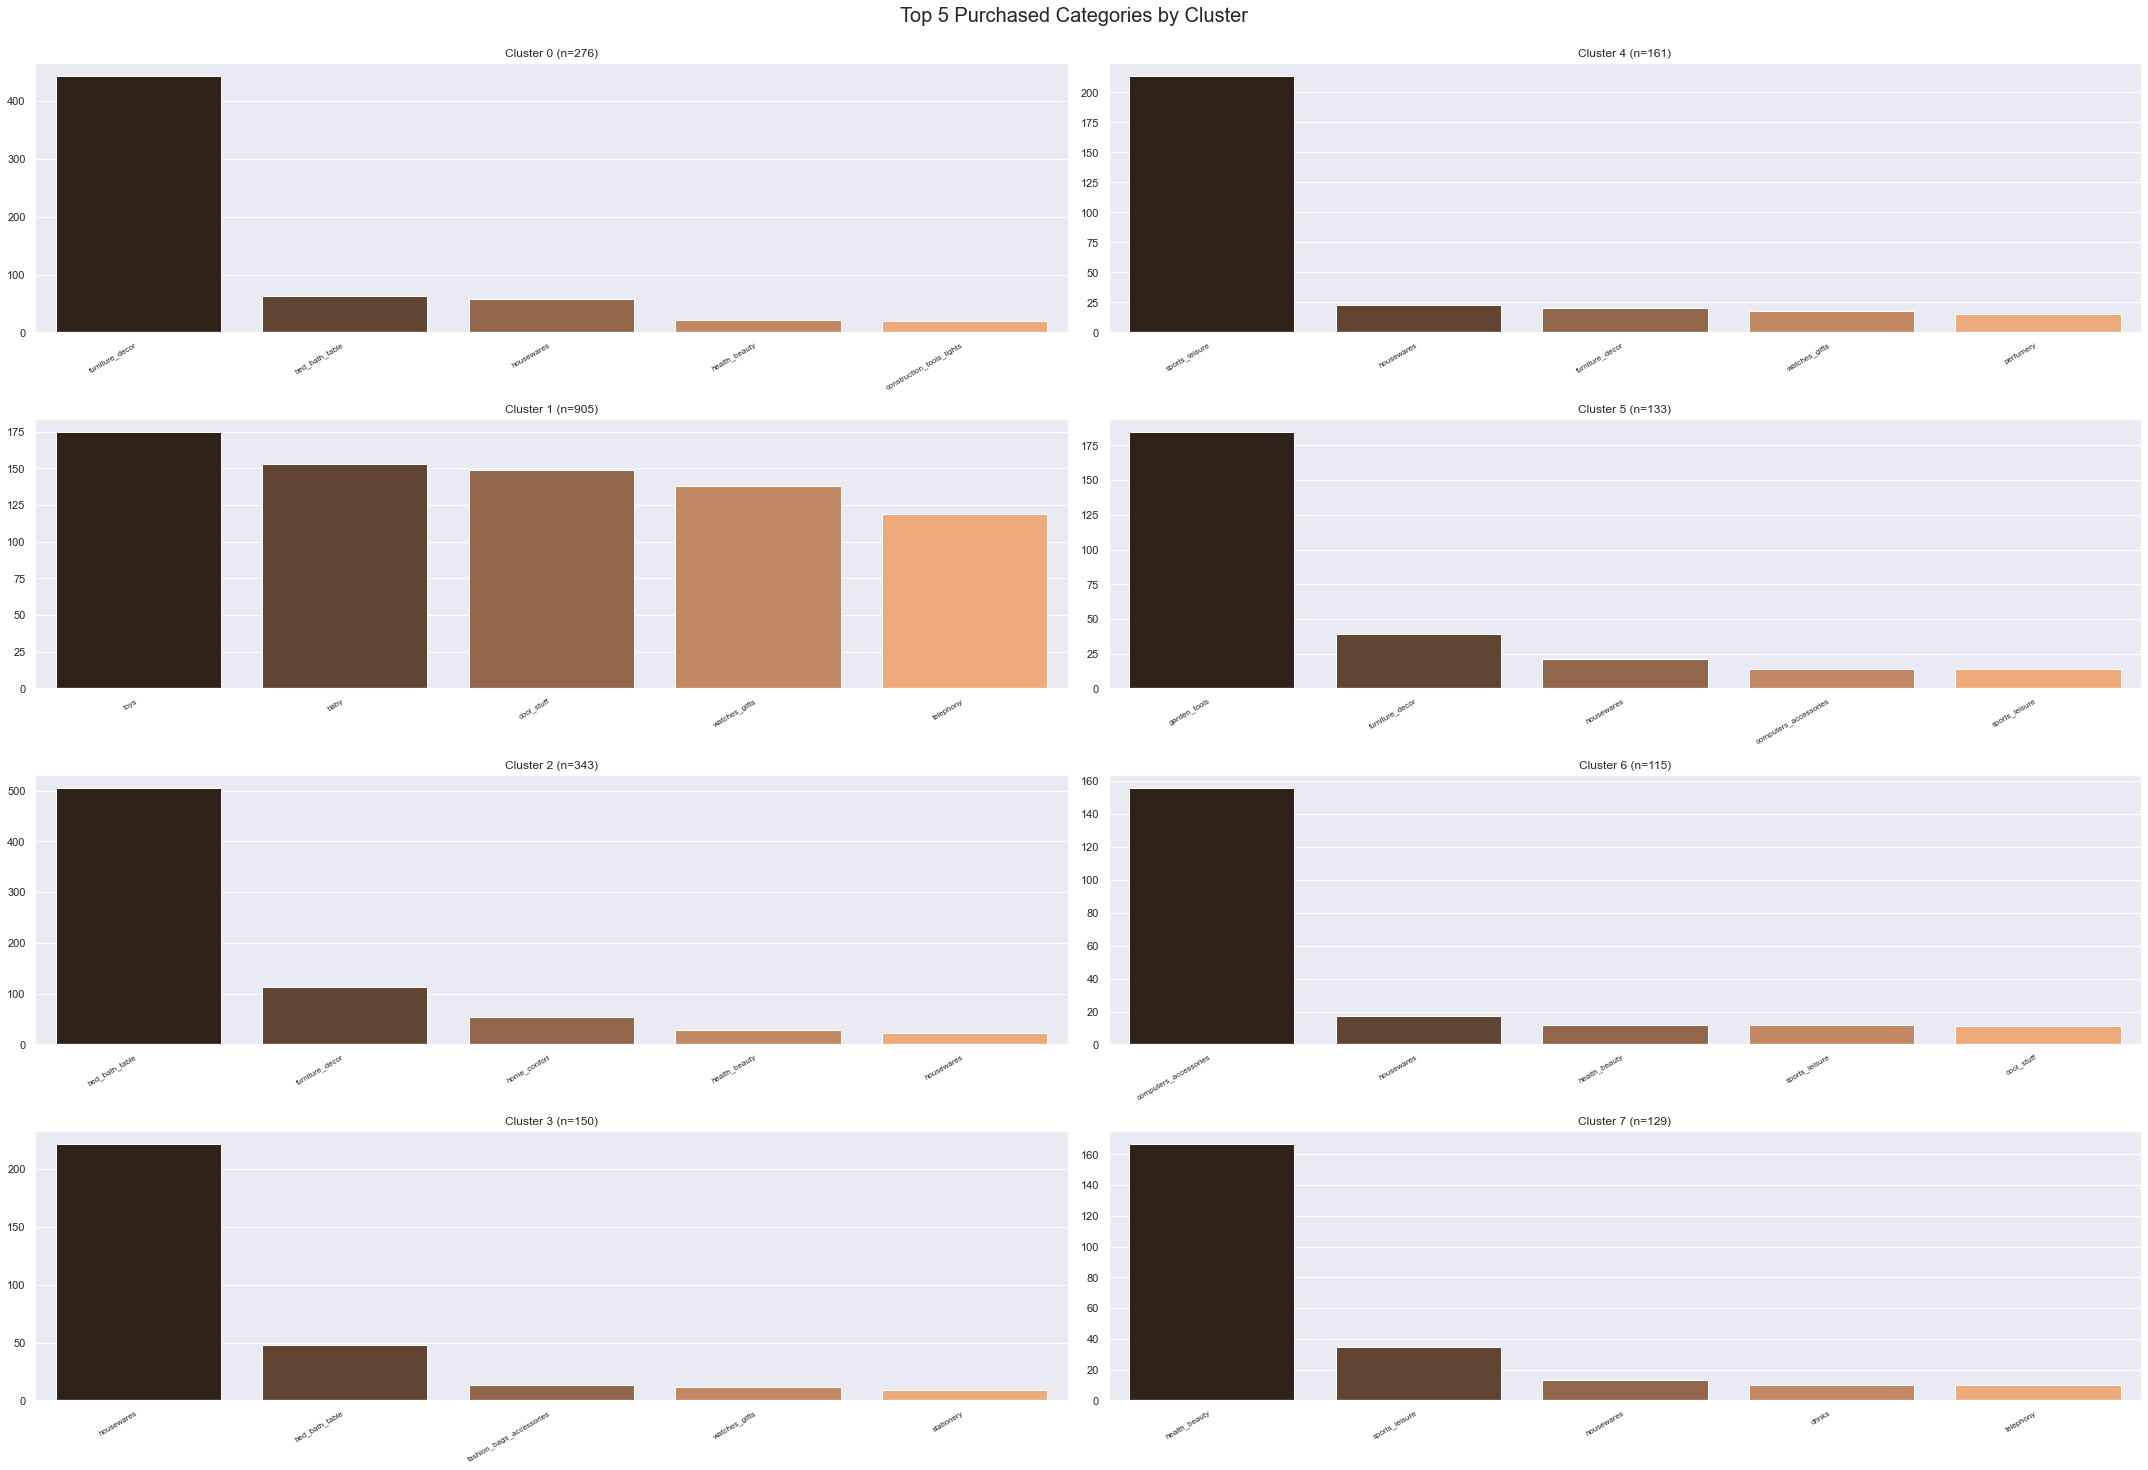

In [21]:
# Get 8 top categories for each cluster 
unique_single['clusters'] = df['Clusters'].values
unique_single.reset_index(drop=True,inplace=True)

cluster_cats = unique_single.groupby('clusters').sum().T

highest_categories = pd.DataFrame()
cat_numbers = pd.DataFrame()

for i in cluster_cats.columns:
    highest_categories[i] = list(cluster_cats[i].nlargest(5).index)

for i in cluster_cats.columns:
    cat_numbers[i] = list(cluster_cats[i].nlargest(5))
    
# Generate 8 separate dfs, each with top 8 categories and number of product orders for each
d = {}

for i in highest_categories.columns:
    cats = pd.DataFrame(highest_categories[i])
    cats = cats.rename(columns={i:'Categories'})
    cats['Total'] = cat_numbers[i].values
    d.update({i:cats})

# Barplots showing the number of product categories purchased within each cluster

rows = round(len(np.unique(clusters)) / 2)

f, ax = plt.subplots(nrows=rows, ncols=2, figsize=(30, 20))

for i in list(d.keys()):
    if i < rows:
        sns.barplot(data=d[i], x='Categories', y='Total',ax=ax[i,0], palette='copper')
        ax[i,0].set_title('Cluster {} (n={})'.format(i,df['Clusters'].value_counts().at[i]))
        ax[i,0].set_ylabel('')
        ax[i,0].set_xlabel('')
        ax[i,0].set_xticklabels(ax[i,0].get_xticklabels(), 
                          rotation=30,
                          fontsize=8,
                          horizontalalignment='right')
    else:
        sns.barplot(data=d[i], x='Categories', y='Total',ax=ax[i-rows,1], palette='copper')
        ax[i-rows,1].set_title('Cluster {} (n={})'.format(i,df['Clusters'].value_counts().at[i]))
        ax[i-rows,1].set_ylabel('')
        ax[i-rows,1].set_xlabel('')
        ax[i-rows,1].set_xticklabels(ax[i-rows,1].get_xticklabels(), 
                          rotation=30,
                          fontsize=8,  
                          horizontalalignment='right')

plt.suptitle("Top 5 Purchased Categories by Cluster", fontsize=20, y=1.02)
plt.tight_layout()


The graph here shows the top 5 product categories within each cluster, and we can see that besides the cluster 1, the other group all have a category that they purchased a lot, and we used that category to name our clusters. We believe based on the result we got from these eight clusters, the company could actually make some different marketing strategies to each of the clusters, like providing discounts or providing recommendations of the same product categories to customers, which may help the company to generate some business values. 

- cluster 0 : futniture_decor
- cluster 1 : toys, baby, cool_stuff, watches_gifts and telephony
- cluster 2 : bed_bath_table
- cluster 3 : housewares
- cluster 4 : sports_leisure	
- cluster 5 : garden_tools
- cluster 6 : computers_accessories
- cluster 7 : health_beauty

In [22]:
highest_categories

,0,1,2,3,4,5,6,7
0,furniture_decor,toys,bed_bath_table,housewares,sports_leisure,garden_tools,computers_accessories,health_beauty
1,bed_bath_table,baby,furniture_decor,bed_bath_table,housewares,furniture_decor,housewares,sports_leisure
2,housewares,cool_stuff,home_confort,fashion_bags_accessories,furniture_decor,housewares,health_beauty,housewares
3,health_beauty,watches_gifts,health_beauty,watches_gifts,watches_gifts,computers_accessories,sports_leisure,drinks
4,construction_tools_lights,telephony,housewares,stationery,perfumery,sports_leisure,cool_stuff,telephony


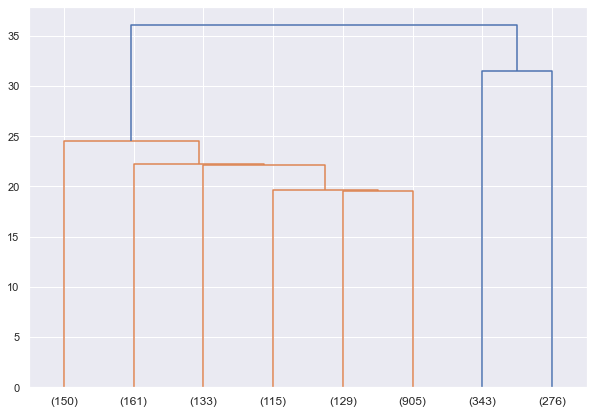

In [23]:
# Implement Scipy dendrogram using AgglomerativeClustering child attribute
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(agglomerative.children_.shape[0])
    n_samples = len(agglomerative.labels_)
    for i, merge in enumerate(agglomerative.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([agglomerative.children_, agglomerative.distances_,
                                      counts]).astype(float)
    
    # Plot the corresponding dendrogram
    plt.figure(figsize=(10,7))
    ddata = dendrogram(linkage_matrix, **kwargs)
    plt.show()

plot_dendrogram(agglomerative, truncate_mode='lastp', p=n_clusters)

Note that the number represents the number of obeservations in each cluster: 
- cluster0(n=276) 
- cluster2(n=343)
- cluster7(n=129)
- cluster1(n=905)
- cluster6(n=115)
- cluster5(n=133)
- cluster3(n=150)
- cluster4(n=161)

We can see from this dendogram how clusters are away from each other. Actually, there are some similarities among some of the clusters. For example, cluster0(n=276) and cluster2(n=343) are similar to each other, they both purchased a lot of Bed, Bath & Table, Furniture & Decor.